# CanESM5 GMD paper Figure 5 
## Pre-industrial control run stability

### history
- SJH, 2019-06-06

CMIP6 variables are:

a) rtmt
b) hfds (ocean) and ? agcm
c) thetao
d) tas
e) wfo
f) zos
g) sivol
h) snw
i) nep?
j) fgco2
k) cLand
l) dissic

For b) to get the agcm value, it must be derived as the sum of the parts, masked with the ocean fraction and integrated. The parts should be: rss, rls, hfls and hfss - the net surface shortwave, longwave, latent and sensible heat fluxes respe(signs need to be checked for consistency). These need to be masked with (1-sftlf), then globally integrated with `areacella` weighting. 

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import numpy as np
import numpy.ma as ma
import os
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import modules.plotting_module as pltm
import datetime
import pickle
from cdo import Cdo

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

In [6]:
CanESM5_dir = 'input_data/CanESM5_cmip_dir/piControl/r1i1p1f1/'
%store -r zeroC_in_K
%store -r cm_per_m
%store -r kg_per_Pg
%store -r seconds_per_day
%store -r days_per_year
%store -r umol_per_mol


In [3]:
#get grid data

#grids
areacella = xr.open_dataset(CanESM5_dir + 'fx/areacella/gn/v20190429/areacella_fx_CanESM5_piControl_r1i1p1f1_gn.nc')['areacella'] #units m2
areacello = xr.open_dataset(CanESM5_dir + 'Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_piControl_r1i1p1f1_gn.nc')['areacello'] #units m2
thkcello  = xr.open_dataset(CanESM5_dir + 'Ofx/thkcello/gn/v20190429/thkcello_Ofx_CanESM5_piControl_r1i1p1f1_gn.nc')['thkcello'] #units m
land_frac = xr.open_dataset(CanESM5_dir + 'fx/sftlf/gn/v20190429/sftlf_fx_CanESM5_piControl_r1i1p1f1_gn.nc')['sftlf'] #units %
ocean_frac = 100-land_frac

land_areacella_merged = xr.merge([land_frac,areacella])
land_cellarea = land_areacella_merged.sftlf/100 * land_areacella_merged.areacella 

In [12]:
preprocess_3D_ocean_vars = False
preprocess_atmos_vars = False
preprocess_atmos_vars_for_heat_flux = True
preprocess_ocean_vars = False

if preprocess_3D_ocean_vars:
    #thetao and dissic - process as separate files b/c 3D variables very slow
    for var in ['thetao','dissic']:
        for file in os.listdir('input_data/CanESM5_cmip_dir/piControl/r1i1p1f1/Omon/'+ var +'/gn/v20190429/'):
            if file.endswith('.nc') and (file + '.pickle' not in os.listdir('input_data/processed_data/fig-05_pictrl/'+ var +'/')):
                print(file, datetime.datetime.now())
                ds = xr.open_dataset('input_data/CanESM5_cmip_dir/piControl/r1i1p1f1/Omon/'+ var +'/gn/v20190429/'+file)[var].groupby('time.year').mean('time')

                #get 3D gridweights
                areas_grid = np.tile(areacello,(len(thkcello.lev),1,1)) 
                gridvolumes = thkcello*areas_grid
                gridvolume_timeseries = ma.masked_invalid(np.tile(gridvolumes,(len(ds.year),1,1,1))) #mask nans or iris will not compute mean

                #convert to iris for weighted means
                iris_model_data = ds.to_iris() 
                iris_model_data.data = ma.masked_invalid(iris_model_data.data) #mask nans or iris will not compute mean
                iris_model_timeseries = iris_model_data.collapsed(['latitude', 'longitude','depth'], iris.analysis.MEAN, weights=gridvolume_timeseries) 
                globalmean = xr.DataArray.from_iris(iris_model_timeseries)
                with open('input_data/processed_data/fig-05_pictrl/'+ var +'/'+file+'.pickle', 'wb') as f:
                    pickle.dump(globalmean, f) 
                    
if preprocess_atmos_vars:        
    #atmos vars
    #concatenate files and save as netcdf
    for atmos_var, table in zip(['tas','rtmt','nep','cLand', 'snw'],['Amon','Amon','Emon','Emon', 'LImon']):
        ds_list = []
        for file in os.listdir(CanESM5_dir + table +'/'+ atmos_var +'/gn/v20190429/'):
            if file.endswith('.nc'):
                data = xr.open_dataset(os.path.join(CanESM5_dir + table +'/'+ atmos_var +'/gn/v20190429/',file))
                ds_list.append(data)
        ds = xr.concat(ds_list, dim='time').sortby('time')        
        ds.to_netcdf('processed_data/fig-05_pictrl/concat_'+ atmos_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc', compute=False, mode='w')

    #open concatenated files, get month-weighted annual means then get grid-weighted timeseries
    for atmos_var, table in zip(['tas','rtmt','nep','cLand','snw'],['Amon','Amon','Emon','Emon', 'LImon']):
        #get annual means
        print(atmos_var)
        var1 = xr.open_dataset('processed_data/fig-05_pictrl/concat_'+ atmos_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc')[atmos_var]
        var = pltm.get_month_weighted_annual_means(var1, 'noleap', '5201-01-16', '6200-12-16')
        #reshape grid cell areas to match var along time dimension
        grid_areas = np.tile(areacella,(len(var.year),1,1)) 
        #convert data array to iris
        iris_model_data = var.to_iris() 
        #get global mean with grid cell area weighting
        iris_model_timeseries = iris_model_data.collapsed(['latitude', 'longitude',], iris.analysis.MEAN, weights=grid_areas) 
        #convert to xarray for plotting and pickle
        globalmean = xr.DataArray.from_iris(iris_model_timeseries)  
        with open('input_data/processed_data/fig-05_pictrl/'+ atmos_var +'_globalmean_pictrl.pickle', 'wb') as f:
            pickle.dump(globalmean, f) 
       
    
if preprocess_atmos_vars_for_heat_flux:            
    #atmos vars used to calc ocean heat flux from agcm - these need to be masked with the ocean fraction 
    #concatenate files and save as netcdf
    for atmos_var, table in zip(['hfls','hfss','rls','rss'],['Amon','Amon','Emon','Emon']):
        ds_list = []
        for file in os.listdir(CanESM5_dir + table +'/'+ atmos_var +'/gn/v20190429/'):
            if file.endswith('.nc'):
                data = xr.open_dataset(os.path.join(CanESM5_dir + table +'/'+ atmos_var +'/gn/v20190429/',file))
                ds_list.append(data)
        ds = xr.concat(ds_list, dim='time').sortby('time')        
        ds.to_netcdf('processed_data/fig-05_pictrl/concat_'+ atmos_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc', compute=False, mode='w')
    
    #open concatenated files, get month-weighted annual means, mask land, then get grid-weighted timeseries
    for atmos_var, table in zip(['hfls','hfss','rls','rss'],['Amon','Amon','Emon','Emon']):
        #get annual means
        print(atmos_var)
        var1 = xr.open_dataset('processed_data/fig-05_pictrl/concat_'+ atmos_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc')[atmos_var]
        var = pltm.get_month_weighted_annual_means(var1, 'noleap', '5201-01-16', '6200-12-16')
        #mask out land - first weight all variable values by fraction of ocean in cell, then mask those cells where ocean fraction = 0
        var = var*ocean_frac/100
        var = var.where(ocean_frac!=0)
        #reshape grid cell areas to match var along time dimension
        grid_areas = ma.masked_invalid(np.tile(areacella,(len(var.year),1,1)))
        #convert data array to iris
        iris_model_data = var.to_iris() 
        iris_model_data.data = ma.masked_invalid(iris_model_data.data)
        #get global mean with grid cell area weighting
        iris_model_timeseries = iris_model_data.collapsed(['latitude', 'longitude',], iris.analysis.MEAN, weights=grid_areas) 
        #convert to xarray for plotting and pickle
        globalmean = xr.DataArray.from_iris(iris_model_timeseries)  
        with open('input_data/processed_data/fig-05_pictrl/'+ atmos_var +'_globalmean_pictrl.pickle', 'wb') as f:
            pickle.dump(globalmean, f) 
    
    
if preprocess_ocean_vars:
    #ocean vars
    #concatenate files and save as netcdf
    for ocean_var, table in zip(['wfo','zos','hfds','fgco2'],['Omon','Omon','Omon','Omon']):
        ds_list = []
        for file in os.listdir(CanESM5_dir + table +'/'+ ocean_var +'/gn/v20190429/'):
            if file.endswith('.nc'):
                print(file)
                data = xr.open_dataset(os.path.join(CanESM5_dir + table +'/'+ ocean_var +'/gn/v20190429/',file))[ocean_var]
                ds_list.append(data)
        ds = xr.concat(ds_list, dim='time').sortby('time')   
        ds.to_netcdf('processed_data/fig-05_pictrl/concat_'+ ocean_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc', compute=False, mode='w')

        
    #open concatenated files, get month-weighted annual means then get grid-weighted timeseries    
    for ocean_var, table in zip(['wfo','zos','hfds','fgco2'],['Omon','Omon','Omon','Omon']):
        #get annual means
        ovar1 = xr.open_dataset('processed_data/fig-05_pictrl/concat_'+ ocean_var +'_'+ table +'_CanESM5_pictrl_5200-6200.nc')[ocean_var]
        ovar = pltm.get_month_weighted_annual_means(ovar1, 'noleap', '5201-01-16', '6200-12-16')
        #reshape grid cell areas to match var along time dimension
        grid_areas = ma.masked_invalid(np.tile(areacello,(len(ovar.year),1,1))) #mask nans or iris will not compute mean
        #convert data array to iris
        iris_model_data = ovar.to_iris() 
        iris_model_data.data = ma.masked_invalid(iris_model_data.data) #mask nans or iris will not compute mean
        #get global mean with grid cell area weighting
        iris_model_timeseries = iris_model_data.collapsed(['latitude', 'longitude',], iris.analysis.MEAN, weights=grid_areas) 
        #convert to xarray for plotting
        globalmean = xr.DataArray.from_iris(iris_model_timeseries)
        with open('input_data/processed_data/fig-05_pictrl/'+ ocean_var +'_globalmean_pictrl.pickle', 'wb') as f:
            pickle.dump(globalmean, f) 

hfls


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


hfss


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


rls


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


rss


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [13]:
#retrieve preprocessed data and convert units as needed

#a rtmt
with open('input_data/processed_data/fig-05_pictrl/rtmt_globalmean_pictrl.pickle', 'rb') as f:
    rtmt_globalmean = pickle.load(f) #units W m-2

#b hfds, rls rss hfls and hfss
b_vars = {}
for var in ['hfds', 'rls', 'rss', 'hfls', 'hfss']:
    with open('input_data/processed_data/fig-05_pictrl/'+ var +'_globalmean_pictrl.pickle', 'rb') as f:
        b_vars[var] = pickle.load(f) #units W m-2

    
#c thetao preprocessed in 10yr increments b/c very slow with larger batches
ds_list = []
for file in os.listdir('input_data/processed_data/fig-05_pictrl/thetao/'):
    with open(os.path.join('input_data/processed_data/fig-05_pictrl/thetao/',file), 'rb') as f:
        ds = pickle.load(f) 
        ds_list.append(ds)
thetao_globalmean = xr.concat(ds_list, dim='year').sortby('year')

    
#d tas
with open('input_data/processed_data/fig-05_pictrl/tas_globalmean_pictrl.pickle', 'rb') as f:
    tas_globalmean = pickle.load(f) 
    tas_globalmean = tas_globalmean - zeroC_in_K  #units K -> degC
    
#e wfo
with open('input_data/processed_data/fig-05_pictrl/wfo_globalmean_pictrl.pickle', 'rb') as f:
    wfo_globalmean = pickle.load(f) 
    wfo_globalmean = wfo_globalmean*1e7  #units kg m-2 s-1 -> x10-7 kg m-2 s-1
    
#f zos
with open('input_data/processed_data/fig-05_pictrl/zos_globalmean_pictrl.pickle', 'rb') as f:
    zos_globalmean = pickle.load(f) 
    zos_globalmean = zos_globalmean*cm_per_m    #units m -> cm
    
#h snw
with open('input_data/processed_data/fig-05_pictrl/snw_globalmean_pictrl.pickle', 'rb') as f:
    snw_globalmean = pickle.load(f) 
    land_area = land_cellarea.sum()
    snw_globalmean = snw_globalmean*land_area*1e-15    #units kg m-2 -> kg
        
#i nep
with open('input_data/processed_data/fig-05_pictrl/nep_globalmean_pictrl.pickle', 'rb') as f:
    nep_globalmean = pickle.load(f) 
    land_area = land_cellarea.sum()
    nep_globalmean = nep_globalmean*seconds_per_day*days_per_year*land_area/kg_per_Pg    #units Kg m-2 s-1 -> PgC yr-1
    
#j fgco2
with open('input_data/processed_data/fig-05_pictrl/fgco2_globalmean_pictrl.pickle', 'rb') as f:
    fgco2_globalmean = pickle.load(f) 
    ocean_area =  areacello.sum()
    fgco2_globalmean = fgco2_globalmean*seconds_per_day*days_per_year*ocean_area/kg_per_Pg    #units Kg m-2 s-1 -> PgC yr-1
    
#k cLand
with open('input_data/processed_data/fig-05_pictrl/cLand_globalmean_pictrl.pickle', 'rb') as f:
    cLand_globalmean = pickle.load(f) 
    land_area = land_cellarea.sum()
    cLand_globalmean = cLand_globalmean*land_area/kg_per_Pg    #units Kg m-2 -> PgC 
    
#l dissic preprocessed in 10yr increments b/c very slow with larger batches
ds_list = []
for file in os.listdir('input_data/processed_data/fig-05_pictrl/dissic/'):
    with open(os.path.join('input_data/processed_data/fig-05_pictrl/dissic/',file), 'rb') as f:
        ds = pickle.load(f) 
        ds_list.append(ds)
dissic_globalmean = xr.concat(ds_list, dim='year').sortby('year')
dissic_globalmean = dissic_globalmean*umol_per_mol/1000    #units mol m-3 -> umol kg-1

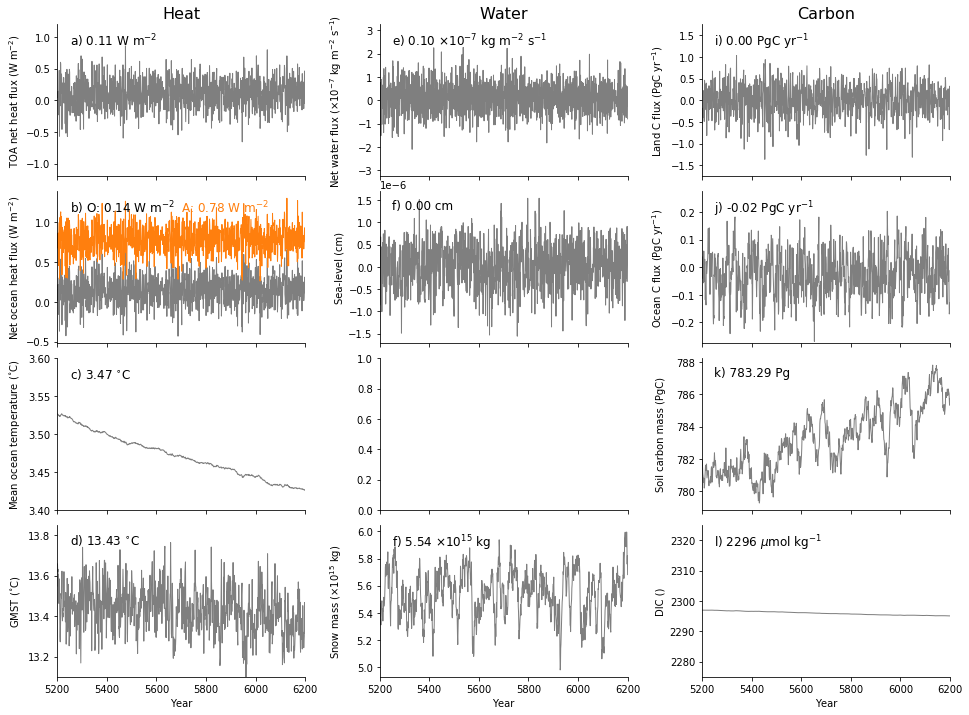

In [19]:
#plotting

fig, ((ax1,ax5, ax9),(ax2, ax6, ax10), (ax3,ax7, ax11), (ax4,ax8, ax12)) = plt.subplots(4,3, sharex=True, sharey=False, figsize=(16,12))
fig.subplots_adjust(wspace=0.3, hspace=0.1)

color='C7'
color2='C1'
linewidth=1

#a
ax1.plot(rtmt_globalmean.year, rtmt_globalmean, color=color, linewidth=linewidth)
ax1.set_xlim(5200,6200)
ax1.set_ylabel('TOA net heat flux (W m$^{-2}$)')
meanval="{0:.2f}".format(round(rtmt_globalmean.mean(dim='year').values.tolist(),2))
ax1.text(0.05, 0.95, 'a) ' + str(meanval) + ' W m$^{-2}$', transform=ax1.transAxes, fontsize=12, ha='left', va='top')
ax1.set_ylim(-1.2,1.2)

#b
scale_factor = 0.71  #*0.71 to scale to m2 of global area
ax2.plot(b_vars['hfds'].year, b_vars['hfds']*scale_factor, color=color, linewidth=linewidth) 
ax2.set_ylabel('Net ocean heat flux (W m$^{-2}$)')
meanval="{0:.2f}".format(round((b_vars['hfds'].mean(dim='year')*scale_factor).values.tolist(),2))
ax2.text(0.05, 0.95,  'b) O: ' + str(meanval) + ' W m$^{-2}$', transform=ax2.transAxes, fontsize=12, ha='left', va='top')

agcm_flux = (-b_vars['hfls']- b_vars['hfss'] + b_vars['rls'] + b_vars['rss'])*scale_factor
ax2.plot(agcm_flux.year, agcm_flux, color=color2, linewidth=linewidth) 
meanval="{0:.2f}".format(round((agcm_flux.mean(dim='year')).values.tolist(),2))
ax2.text(0.5, 0.95,  'A: ' + str(meanval) + ' W m$^{-2}$', transform=ax2.transAxes, fontsize=12, ha='left', va='top', color=color2)

#c
ax3.plot(thetao_globalmean.year, thetao_globalmean, color=color, linewidth=linewidth)
ax3.set_ylim([3.4,3.6])
ax3.set_ylabel('Mean ocean temperature ($^{\circ}$C)')
meanval="{0:.2f}".format(round((thetao_globalmean).mean(dim='year').values.tolist(),2))
ax3.text(0.05, 0.95, 'c) ' + str(meanval) + ' $^{\circ}$C', transform=ax3.transAxes, fontsize=12, ha='left', va='top')

#d
ax4.plot(tas_globalmean.year, tas_globalmean, color=color, linewidth=linewidth)
ax4.set_ylabel('GMST ($^{\circ}$C)')
meanval="{0:.2f}".format(round(tas_globalmean.mean(dim='year').values.tolist(),2))
ax4.text(0.05, 0.95, 'd) ' +str(meanval) + ' $^{\circ}$C', transform=ax4.transAxes, fontsize=12, ha='left', va='top')
ax4.set_ylim(13.1,13.85)

#e
ax5.plot(wfo_globalmean.year, wfo_globalmean, color=color, linewidth=linewidth)
ax5.set_ylabel(r'Net water flux ($\times 10^{-7}$ kg m$^{-2}$ s$^{-1}$)')
meanval="{0:.2f}".format(round((wfo_globalmean).mean(dim='year').values.tolist(),2))
ax5.text(0.05, 0.95, 'e) ' +str(meanval) + r' $\times 10^{-7}$ kg m$^{-2}$ s$^{-1}$', transform=ax5.transAxes, fontsize=12, ha='left', va='top')
ax5.set_ylim(-3.25,3.25)

#f
ax6.plot(zos_globalmean.year, zos_globalmean, color=color, linewidth=linewidth)
ax6.set_ylabel('Sea-level (cm)')
meanval="{0:.2f}".format(round((zos_globalmean).mean(dim='year').values.tolist(),2))
ax6.text(0.05, 0.95, 'f) ' +str(meanval) + ' cm', transform=ax6.transAxes, fontsize=12, ha='left', va='top')
ax6.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#h
ax8.plot(snw_globalmean.year, snw_globalmean, color=color, linewidth=linewidth)
ax8.set_ylabel(r'Snow mass ($\times 10^{15}$ kg)')
meanval="{0:.2f}".format(round((snw_globalmean).mean(dim='year').values.tolist(),2))
ax8.text(0.05, 0.95, 'f) ' +str(meanval) + r' $\times 10^{15}$ kg', transform=ax8.transAxes, fontsize=12, ha='left', va='top')
ax8.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#i
ax9.plot(nep_globalmean.year, nep_globalmean, color=color, linewidth=linewidth)
ax9.set_ylabel('Land C flux (PgC yr$^{-1}$)')
meanval="{0:.2f}".format(round(nep_globalmean.mean(dim='year').values.tolist(),2))
ax9.text(0.05, 0.95, 'i) ' +str(meanval) + ' PgC yr$^{-1}$', transform=ax9.transAxes, fontsize=12, ha='left', va='top')
ax9.set_ylim(-1.75,1.75)

#j
ax10.plot(fgco2_globalmean.year, fgco2_globalmean, color=color, linewidth=linewidth)
ax10.set_ylabel('Ocean C flux (PgC yr$^{-1}$)')
meanval="{0:.2f}".format(round(fgco2_globalmean.mean(dim='year').values.tolist(),2))
ax10.text(0.05, 0.95, 'j) ' +str(meanval) + ' PgC yr$^{-1}$', transform=ax10.transAxes, fontsize=12, ha='left', va='top')
ax10.set_ylim(-0.275,0.275)

#k
ax11.plot(cLand_globalmean.year, cLand_globalmean, color=color, linewidth=linewidth)
ax11.set_ylabel(r'Soil carbon mass (PgC)')
meanval="{0:.2f}".format(round(cLand_globalmean.mean(dim='year').values.tolist(),2))
ax11.text(0.05, 0.95, 'k) ' +str(meanval) + r' Pg', transform=ax11.transAxes, fontsize=12, ha='left', va='top')
#ax11.set_ylim(740,840)

#l
ax12.plot(dissic_globalmean.year, dissic_globalmean, color=color, linewidth=linewidth)
ax12.set_ylabel(r'DIC ()')
meanval="{0:.0f}".format(round((dissic_globalmean).mean(dim='year').values.tolist(),2))
ax12.text(0.05, 0.95, 'l) ' +str(meanval) + r' $\mu$mol kg$^{-1}$', transform=ax12.transAxes, fontsize=12, ha='left', va='top')
ax12.set_ylim(2275,2325)


ax1.set_title('Heat', fontsize=16)
ax5.set_title('Water', fontsize=16)
ax9.set_title('Carbon', fontsize=16)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
fig.align_ylabels(axs)

for ax in [ax4, ax8, ax12]:
    ax.set_xlabel('Year')


In [3]:
ds = xr.open_dataset('processed_data/sc_rc3.1-pictrl_5201_6542_rtd074.nc')

# The below have been annually averaged with cdo yearmonmean.
dso = xr.open_dataset('processed_data/ym_sc_rc3.1-pictrl_5201_6415_nemo_physical_rtd.nc') 
dsoc = xr.open_dataset('processed_data/ym_sc_rc3.1-pictrl_5201_6415_nemo_carbon_rtd.nc') 
dsoi = xr.open_dataset('processed_data/ym_sc_rc3.1-pictrl_5201_6415_nemo_ice_rtd.nc') 

time = ds.time
year = time + 5201
linewidth=1


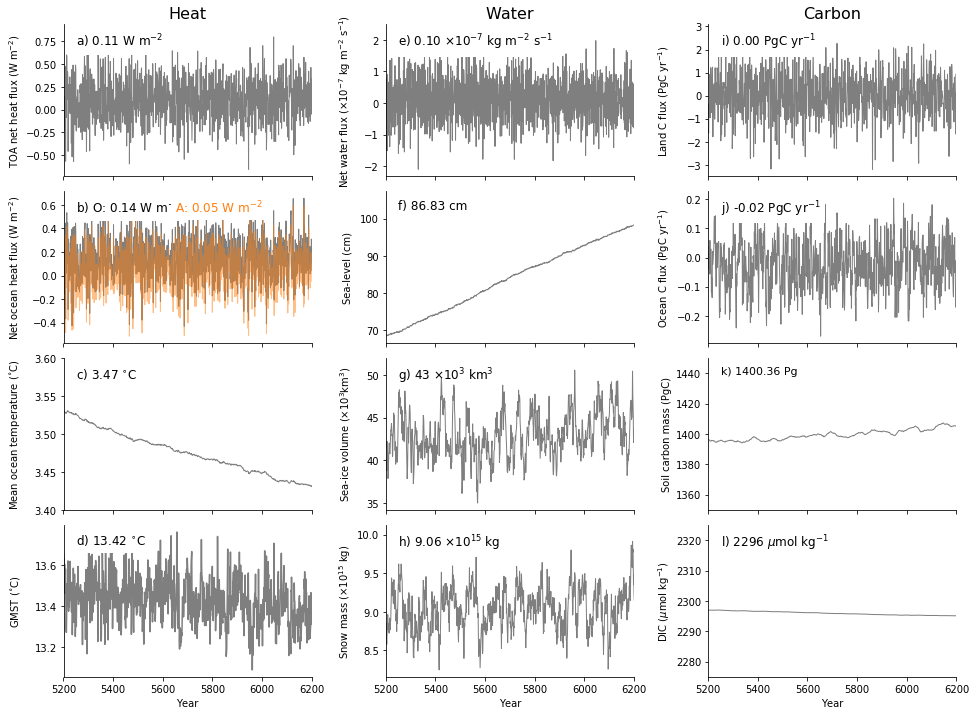

In [7]:
color='C7'
color2='C1'

fig, ((ax1,ax5, ax9),(ax2, ax6, ax10), (ax3,ax7, ax11), (ax4,ax8, ax12)) = plt.subplots(4,3, sharex=True, sharey=False, figsize=(16,12))
fig.subplots_adjust(wspace=0.3, hspace=0.1)


ax1.plot(year, ds['NET_TOA_ENERGY_GLOBAL_BALT__WpM2______________ANN_00001'], color=color, linewidth=linewidth)
#ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_ylabel('TOA net heat flux (W m$^{-2}$)')
meanval="{0:.2f}".format(round(ds['NET_TOA_ENERGY_GLOBAL_BALT__WpM2______________ANN_00001'].mean(dim='time').values.tolist(),2))
ax1.text(0.05, 0.95, 'a) ' + str(meanval) + ' W m$^{-2}$', transform=ax1.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')


ax2.plot(dso.time.dt.year, dso.hglo*0.71, color=color, linewidth=linewidth)#*0.71 to scale to m2 of global area
lfus=110.121e+6/330
bego=ds['NET_SFC_ENERGY_OPEN_WATER_BEGO__WpM2__________ANN_00001']
begi=ds['NET_SFC_ENERGY_SEAICE_BEGI__WpM2______________ANN_00001']
snow=ds['GLOBAL_SNOWFALL_RATE_OCEAN__KGpM2pS___________ANN_00001']
snowi=ds['GLOBAL_SNOWFALL_RATE_SEAICE__KGpM2pS__________ANN_00001']
#snow=ds['GLOBAL_SNOWFALL_RATE_WATER__KGpM2pS___________ANN_00001']

ga=ds['GLOBAL_AREA__M2_______________________________ANN_00001']
oa=ds['OCEAN_AREA__M2________________________________ANN_00001']


net_heat = begi + bego - (snow)*lfus*ga/oa

ax2.plot(year, net_heat*0.71, alpha=0.5, color=color2, linewidth=linewidth) #*0.71 to scale to m2 of global area
#ax2.axhline(y=0, color='k', zorder=0)
#ax2.axhline(y=0, color='k', linestyle='--')
#ax2.plot(dso.time.dt.year, dso.hflx_qsr_tot+dso.hflx_qns_tot, alpha=0.1)
ax2.set_ylabel('Net ocean heat flux (W m$^{-2}$)')
meanval="{0:.2f}".format(round((dso.hglo*0.71).mean(dim='time').values.tolist(),2))
ax2.text(0.05, 0.95,  'b) O: ' + str(meanval) + ' W m$^{-2}$', transform=ax2.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

meanval2="{0:.2f}".format(round((net_heat*0.71).mean(dim='time').values.tolist(),2))
ax2.text(0.45, 0.95,  'A: ' + str(meanval2) + ' W m$^{-2}$', transform=ax2.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w',
        color=color2)

ax3.plot(dso.time.dt.year, dso['T'], color=color, linewidth=linewidth)
ax3.set_ylim([3.4,3.6])
#ax3.axhline(y=3.5, color='k', zorder=0)
ax3.set_ylabel('Mean ocean temperature ($^{\circ}$C)')
meanval="{0:.2f}".format(round((dso['T']).mean(dim='time').values.tolist(),2))
ax3.text(0.05, 0.95, 'c) ' +str(meanval) + ' $^{\circ}$C', transform=ax3.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

ax4.plot(year, ds['SCREEN_TEMPERATURE_GLOBAL__K__________________ANN_00001']-273.15, color=color)
#ax4.axhline(y=13.5, color='k', zorder=0)
ax4.set_ylabel('GMST ($^{\circ}$C)')
meanval="{0:.2f}".format(round(ds['SCREEN_TEMPERATURE_GLOBAL__K__________________ANN_00001'].mean(dim='time').values.tolist()-273.15,2))
ax4.text(0.05, 0.95, 'd) ' +str(meanval) + ' $^{\circ}$C', transform=ax4.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

##########################
ax5.plot(dso.time.dt.year, dso.wglo*-1, color=color, linewidth=linewidth)
#ax5.axhline(y=0, color='k', zorder=0)
#ax5.axhline(y=0, color='k', linestyle='--')
ax5.set_ylabel(r'Net water flux ($\times 10^{-7}$ kg m$^{-2}$ s$^{-1}$)')
meanval="{0:.2f}".format(round((dso.wglo*-1).mean(dim='time').values.tolist(),2))
ax5.text(0.05, 0.95, 'e) ' +str(meanval) + r' $\times 10^{-7}$ kg m$^{-2}$ s$^{-1}$', transform=ax5.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

ax6.plot(dso.time.dt.year, dso.sshglo, color=color, linewidth=linewidth)
#ax5.axhline(y=0, color='k', zorder=0)
ax6.set_ylabel('Sea-level (cm)')
meanval="{0:.2f}".format(round((dso.sshglo).mean(dim='time').values.tolist(),2))
ax6.text(0.05, 0.95, 'f) ' +str(meanval) + ' cm', transform=ax6.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

ax7.plot(dsoi.time.dt.year, (dsoi.Volume_NH + dsoi.Volume_SH)/1e12, color=color, linewidth=linewidth)
ax7.set_ylabel(r'Sea-ice volume ($\times 10^3$km$^3$)')
meanval="{0:.0f}".format(round(((dsoi.Volume_NH + dsoi.Volume_SH)/1e12).mean(dim='time').values.tolist(),2))
ax7.text(0.05, 0.95, 'g) ' +str(meanval) + r' $\times 10^3$ km$^3$', transform=ax7.transAxes, fontsize=12, ha='left', va='top')

ax8.plot(year, ds['SNOW_MASS_GLOBAL__KG__________________________ANN_00001']/1e15, color=color, linewidth=linewidth)
#ax6.axhline(y=13.5, color='k', zorder=0)
ax8.set_ylabel(r'Snow mass ($\times 10^{15}$ kg)')
meanval="{0:.2f}".format(round(ds['SNOW_MASS_GLOBAL__KG__________________________ANN_00001'].mean(dim='time').values.tolist()/1e15,2))
ax8.text(0.05, 0.95, 'h) ' +str(meanval) + r' $\times 10^{15}$ kg', transform=ax8.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')
############################

ax9.plot(year, ds['NET_BIOME_PRODUCTIVITY__PG_CpYR_______________ANN_00001'], color=color, linewidth=linewidth)
#ax9.axhline(y=0, color='k', zorder=0)
#ax9.axhline(y=0, color='k', linestyle='--')
ax9.set_ylabel('Land C flux (PgC yr$^{-1}$)')
meanval="{0:.2f}".format(round(ds['NET_BIOME_PRODUCTIVITY__PG_CpYR_______________ANN_00001'].mean(dim='time').values.tolist(),2))
ax9.text(0.05, 0.95, 'i) ' +str(meanval) + ' PgC yr$^{-1}$', transform=ax9.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

ax10.plot(dsoc.time.dt.year, dsoc.CFLX, color=color, linewidth=linewidth)
#ax10.axhline(y=0, color='k', zorder=0)
#ax10.axhline(y=0, color='k', linestyle='--')
ax10.set_ylabel('Ocean C flux (PgC yr$^{-1}$)')
meanval="{0:.2f}".format(round(dsoc.CFLX.mean(dim='time').values.tolist(),2))
ax10.text(0.05, 0.95, 'j) ' +str(meanval) + ' PgC yr$^{-1}$', transform=ax10.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')

ax11.plot(year, ds['SOIL_CARBON_MASS__PG_C________________________ANN_00001'], color=color, linewidth=linewidth)
#ax6.axhline(y=13.5, color='k', zorder=0)
ax11.set_ylabel(r'Soil carbon mass (PgC)')
meanval="{0:.2f}".format(round(ds['SOIL_CARBON_MASS__PG_C________________________ANN_00001'].mean(dim='time').values.tolist(),2))
ax11.text(0.05, 0.95, 'k) ' +str(meanval) + r' Pg', transform=ax11.transAxes, fontsize=11, ha='left', va='top', backgroundcolor='w')
ax11.set_ylim([1350,1450])

ax12.plot(dsoc.time.dt.year, dsoc['DIC'], color=color, linewidth=linewidth)
ax12.set_ylabel(r'DIC ($\mu$mol kg$^{-1}$)')
meanval="{0:.0f}".format(round((dsoc['DIC']).mean(dim='time').values.tolist(),2))
ax12.text(0.05, 0.95, 'l) ' +str(meanval) + r' $\mu$mol kg$^{-1}$', transform=ax12.transAxes, fontsize=12, ha='left', va='top', backgroundcolor='w')
ax12.set_ylim([2275,2325])

ax1.set_title('Heat', fontsize=16)
ax5.set_title('Water', fontsize=16)
ax9.set_title('Carbon', fontsize=16)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
ax5.set_xlim([5201,6200])
fig.align_ylabels(axs)

for ax in [ax4, ax8, ax12]:
    ax.set_xlabel('Year')

fig.savefig('plots/fig-03_canesm5-pistab.png', bbox_inches='tight')
fig.savefig('plots/fig-03_canesm5-pistab.pdf', bbox_inches='tight')